Был использован датасет, полученный по следующей ссылке: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification/data

##1. Загрузка пакетов - библиотек

In [ ]:
# Импорт необходимых библиотек
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
import random
import math
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import pandas as pd

# Установка seed для воспроизводимости результатов
np.random.seed(17)
tf.random.set_seed(17)


##2. Загрузка датасета

In [ ]:
dataset_root = Path("/content/iad-lab3/Vehicles")

# Проверка наличия датасета
if dataset_root.exists():
    print("Датасет уже найден по указанному пути.")
else:
    print("Датасет не найден. Выполняется загрузка с GitHub...")
    !git clone https://github.com/Daria-Chernykh/iad-lab3.git

# Получение списка классов (подкаталогов)
class_names = sorted(
    [item.name for item in dataset_root.iterdir() if item.is_dir()]
)

# Фиксация количества классов
num_classes = len(class_names)

print("\nНайденные классы:")
for idx, class_name in enumerate(class_names):
    print(f"{idx + 1}. {class_name}")

print(f"\nКоличество классов k = {num_classes}")

# Допустимые расширения изображений (в нижнем регистре)
image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".webp"}

# Подсчёт количества изображений в каждой папке класса
print("\nКоличество изображений по классам:")

total_images = 0

for class_name in class_names:
    class_path = dataset_root / class_name

    num_images = sum(
        1 for f in class_path.iterdir()
        if f.is_file() and f.suffix.lower() in image_extensions
    )

    total_images += num_images
    print(f"{class_name}: {num_images}")

print(f"\nОбщее количество изображений в датасете: {total_images}")

Датасет уже найден по указанному пути.

Найденные классы:
1. Auto Rickshaws
2. Bikes
3. Cars
4. Motorcycles
5. Planes
6. Ships
7. Trains

Количество классов k = 7

Количество изображений по классам:
Auto Rickshaws: 800
Bikes: 800
Cars: 790
Motorcycles: 800
Planes: 800
Ships: 800
Trains: 800

Общее количество изображений в датасете: 5590


В лабораторной работе используется датасет изображений транспортных средств (Vehicles). Набор данных включает 7 классов:
* Авторикши (Auto Rickshaws),
* Велосипеды (Bikes),
* Машины (Cars),
* Мотоциклы (Motorcycles),
* Самолеты (Planes),
* Корабли (Ships),
* Поезда (Trains).

Каждый класс представлен отдельной папкой с изображениями. Общее количество изображений в датасете составляет 5590. Число изображений в классах близко по величине (от 790 до 800 изображений на класс), что позволяет считать датасет практически сбалансированным и пригодным для решения задачи многоклассовой классификации с использованием сверточных нейронных сетей.

##3. Выбор и фиксация размерности изображений

In [ ]:
# Фиксация размерности входных изображений
img_height = 128
img_width = 128
input_shape = (img_height, img_width, 3)

# Размер мини-пакета
batch_size = 128

##4. Формирование обучающей, валидационной и тестовой выборок

####4.1 Физическое разбиение датасета по папкам

In [ ]:
source_root = Path("/content/iad-lab3/Vehicles")
target_root = Path("/content/Vehicles_split")

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".webp"}

# Если папка разбиения уже существует — полностью удалить
if target_root.exists():
    shutil.rmtree(target_root)

# Создание структуры каталогов
for split in ["train", "val", "test"]:
    for class_dir in source_root.iterdir():
        if class_dir.is_dir():
            (target_root / split / class_dir.name).mkdir(parents=True, exist_ok=True)

# Разбиение изображений по классам
for class_dir in source_root.iterdir():
    if not class_dir.is_dir():
        continue

    images = [
        img for img in class_dir.iterdir()
        if img.is_file() and img.suffix.lower() in image_extensions
    ]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]

    for img in train_images:
        shutil.copy(img, target_root / "train" / class_dir.name / img.name)

    for img in val_images:
        shutil.copy(img, target_root / "val" / class_dir.name / img.name)

    for img in test_images:
        shutil.copy(img, target_root / "test" / class_dir.name / img.name)

print("Разбиение датасета на train / val / test выполнено корректно.")


Разбиение датасета на train / val / test выполнено корректно.


####4.2 Создание генераторов изображений

In [ ]:
# Генераторы изображений
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

val_test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

# Обучающая выборка
train_generator = train_datagen.flow_from_directory(
    target_root / "train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

# Валидационная выборка
val_generator = val_test_datagen.flow_from_directory(
    target_root / "val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

# Тестовая выборка
test_generator = val_test_datagen.flow_from_directory(
    target_root / "test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 3353 images belonging to 7 classes.
Found 1118 images belonging to 7 classes.
Found 1116 images belonging to 7 classes.


####4.3 Вывод количества изображений в каждой выборке

In [ ]:
num_train = train_generator.samples
num_val = val_generator.samples
num_test = test_generator.samples

print("Количество изображений в выборках:")
print(f"Обучающая выборка: {num_train}")
print(f"Валидационная выборка: {num_val}")
print(f"Тестовая выборка: {num_test}")
print(f"Общее количество изображений: {num_train + num_val + num_test}")

Количество изображений в выборках:
Обучающая выборка: 3353
Валидационная выборка: 1118
Тестовая выборка: 1116
Общее количество изображений: 5587


Исходный датасет был физически разделён на обучающую, валидационную и тестовую выборки в соотношении 60% / 20% / 20% отдельно для каждого класса. Генераторы изображений использовались для загрузки данных из каталогов, изменения размера изображений и нормализации значений пикселей.

##5. Построение сверточной нейронной сети «с нуля»

In [ ]:
# 5.1. Настройка callback-функций обучения
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# 5.2. Слой аугментации данных
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ],
    name="data_augmentation"
)

# 5.3. Определение архитектуры сверточной нейронной сети
def create_simple_cnn():
    inputs = layers.Input(shape=input_shape)

    # Аугментация изображений
    x = data_augmentation(inputs)

    # Сверточная часть сети
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Переход к полносвязной части
    x = layers.Flatten()(x)

    # Полносвязный классификатор
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# 5.4. Компиляция модели
model = create_simple_cnn()

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# 5.5. Обучение модели
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=math.ceil(num_train / batch_size),
    validation_steps=math.ceil(num_val / batch_size),
    callbacks=callbacks,
    verbose=1
)

# 5.6. Оценка модели на тестовой выборке
test_results = model.evaluate(
    test_generator,
    steps=math.ceil(num_test / batch_size),
    verbose=1
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.1789 - loss: 2.0774 - val_accuracy: 0.4043 - val_loss: 1.5831
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.3415 - loss: 1.6616 - val_accuracy: 0.5313 - val_loss: 1.3608
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - accuracy: 0.5112 - loss: 1.3810 - val_accuracy: 0.5984 - val_loss: 1.1456
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - accuracy: 0.5010 - loss: 1.3681 - val_accuracy: 0.6181 - val_loss: 1.0982
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.5898 - loss: 1.1566 - val_accuracy: 0.6583 - val_loss: 1.0237
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.6006 - loss: 1.1254 - val_accuracy: 0.6306 - val_loss: 1.1682
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.6282 - loss: 1.0674 - val_accuracy: 0.7129 - val_loss: 0.8958
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 179s 7s/step - accuracy: 0.6674 - loss: 0.9748 - val_accuracy: 0.7021 - v

In [ ]:
print("\n" + "=" * 60)
print("ОЦЕНКА МОДЕЛИ")
print("=" * 60)

print(f"Потери (loss): {test_results[0]:.4f}")
print(f"Точность (accuracy): {test_results[1]:.4f} ({test_results[1]*100:.1f}%)")


ОЦЕНКА МОДЕЛИ
Потери (loss): 0.5318
Точность (accuracy): 0.8405 (84.1%)


В результате обучения сверточной нейронной сети, построенной «с нуля», была получена устойчивая сходимость процесса оптимизации. Значение функции потерь монотонно уменьшалось как на обучающей, так и на валидационной выборках, что свидетельствует о корректной настройке архитектуры модели и параметров обучения.

Итоговая точность классификации на тестовой выборке составила 84.1%, что является удовлетворительным результатом для модели, не использующей предобученные веса. Разница между обучающей и валидационной точностью остаётся умеренной, что указывает на отсутствие выраженного переобучения и адекватную обобщающую способность модели.

Применение аугментации данных на уровне слоёв позволило повысить разнообразие обучающих примеров без искажения валидационных и тестовых данных. Использование ранней остановки обеспечило выбор оптимальных весов модели и предотвратило деградацию качества при дальнейшем обучении.

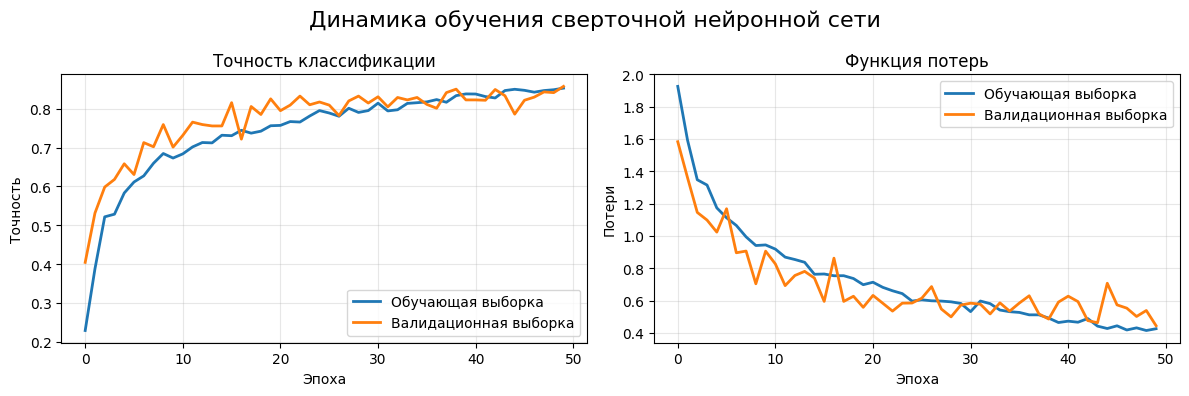

In [ ]:
# 5.7. Визуализация изменения точности и функции потерь в процессе обучения
def plot_training_results(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Точность классификации
    axes[0].plot(history.history["accuracy"], label="Обучающая выборка", linewidth=2)
    axes[0].plot(history.history["val_accuracy"], label="Валидационная выборка", linewidth=2)
    axes[0].set_title("Точность классификации")
    axes[0].set_xlabel("Эпоха")
    axes[0].set_ylabel("Точность")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Функция потерь
    axes[1].plot(history.history["loss"], label="Обучающая выборка", linewidth=2)
    axes[1].plot(history.history["val_loss"], label="Валидационная выборка", linewidth=2)
    axes[1].set_title("Функция потерь")
    axes[1].set_xlabel("Эпоха")
    axes[1].set_ylabel("Потери")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("Динамика обучения сверточной нейронной сети", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_training_results(history)

На графике точности классификации видно устойчивое увеличение accuracy как на обучающей, так и на валидационной выборках. Уже в первые эпохи наблюдается резкий рост качества, что указывает на способность модели эффективно извлекать базовые визуальные признаки изображений. В дальнейшем рост точности замедляется и выходит на плато, что является ожидаемым поведением при обучении сверточной нейронной сети.

Кривые обучающей и валидационной точности располагаются близко друг к другу, без выраженного расхождения. Это свидетельствует об отсутствии сильного переобучения и корректно подобранной сложности модели. Использование аугментации данных и метода ранней остановки положительно сказалось на обобщающей способности сети.

График функции потерь демонстрирует монотонное снижение значений loss на обеих выборках. Валидационная функция потерь повторяет общий тренд обучающей, не проявляя резкого роста, что также подтверждает стабильность процесса обучения. Небольшие колебания валидационной кривой являются нормальными и связаны со стохастической природой градиентного спуска и аугментации данных.

В целом, анализ графиков показывает, что модель, построенная «с нуля», успешно обучается, достигая приемлемого уровня точности при сохранении баланса между качеством обучения и обобщающей способностью.

In [ ]:
# 5.8. Анализ полученных результатов
print("\n" + "=" * 60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
print("=" * 60)

best_val_acc = max(history.history["val_accuracy"])
best_val_loss = min(history.history["val_loss"])
final_train_acc = history.history["accuracy"][-1]
final_val_acc = history.history["val_accuracy"][-1]

print("Основные показатели качества модели:")
print(f"  Лучшая валидационная точность: {best_val_acc:.4f} ({best_val_acc*100:.1f}%)")
print(f"  Минимальные валидационные потери: {best_val_loss:.4f}")
print(f"  Финальная обучающая точность: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"  Финальная валидационная точность: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"  Точность на тестовой выборке: {test_results[1]:.4f} ({test_results[1]*100:.1f}%)")

overfitting_gap = final_train_acc - final_val_acc
print("\nАнализ переобучения:")
print(f"  Разница между обучающей и валидационной точностью: {overfitting_gap:.4f}")


АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ
Основные показатели качества модели:
  Лучшая валидационная точность: 0.8578 (85.8%)
  Минимальные валидационные потери: 0.4443
  Финальная обучающая точность: 0.8533 (85.3%)
  Финальная валидационная точность: 0.8578 (85.8%)
  Точность на тестовой выборке: 0.8405 (84.1%)

Анализ переобучения:
  Разница между обучающей и валидационной точностью: -0.0045


По результатам обучения сверточной нейронной сети, построенной «с нуля», была достигнута высокая точность классификации изображений транспортных средств. Лучшая валидационная точность составила 85.8%, при этом точность на тестовой выборке достигла 84.1%, что указывает на хорошую обобщающую способность модели.

Минимальное значение функции потерь на валидационной выборке составило 0.4443, что подтверждает корректную сходимость процесса обучения. Финальные значения обучающей и валидационной точности практически совпадают, а разница между ними составляет −0.0045, что свидетельствует об отсутствии выраженного переобучения.

Использование аугментации данных и метода ранней остановки позволило стабилизировать процесс обучения и предотвратить ухудшение качества модели на валидационных данных. Полученные результаты демонстрируют, что даже относительно простая сверточная архитектура без использования предобученных весов способна эффективно решать задачу многоклассовой классификации изображений при корректной настройке параметров обучения.

### 6. Построение сверточной нейронной сети с трансферным обучением

In [ ]:
# Генераторы для transfer learning (БЕЗ rescale)
train_datagen_tl = ImageDataGenerator()
val_test_datagen_tl = ImageDataGenerator()

train_generator_tl = train_datagen_tl.flow_from_directory(
    target_root / "train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator_tl = val_test_datagen_tl.flow_from_directory(
    target_root / "val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator_tl = val_test_datagen_tl.flow_from_directory(
    target_root / "test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 3353 images belonging to 7 classes.
Found 1118 images belonging to 7 classes.
Found 1116 images belonging to 7 classes.


In [ ]:
# 6.1. Настройка callback-функций обучения
callbacks_tl = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# 6.2. Слой аугментации данных
data_augmentation_tl = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ],
    name="data_augmentation_tl"
)

# 6.3. Загрузка предобученной сверточной базы
conv_base = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

conv_base.trainable = False

# 6.4. Построение модели с трансферным обучением
def create_transfer_learning_model():
    inputs = layers.Input(shape=input_shape)

    # Аугментация изображений
    x = data_augmentation_tl(inputs)

    # Предобработка под ResNet50V2
    x = preprocess_input(x)

    # Предобученная сверточная база
    x = conv_base(x, training=False)

    # Классификатор
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# 6.5. Компиляция модели
transfer_model = create_transfer_learning_model()

transfer_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# 6.6. Обучение модели
history_tl = transfer_model.fit(
    train_generator_tl,
    validation_data=val_generator_tl,
    epochs=30,
    steps_per_epoch=math.ceil(num_train / batch_size),
    validation_steps=math.ceil(num_val / batch_size),
    callbacks=callbacks_tl,
    verbose=1
)

# 6.7. Оценка модели на тестовой выборке
test_results_tl = transfer_model.evaluate(
    test_generator_tl,
    steps=math.ceil(num_test / batch_size),
    verbose=1
)

print("\n" + "=" * 60)
print("ОЦЕНКА МОДЕЛИ С ТРАНСФЕРНЫМ ОБУЧЕНИЕМ")
print("=" * 60)

print(f"Потери (loss): {test_results_tl[0]:.4f}")
print(f"Точность (accuracy): {test_results_tl[1]:.4f} ({test_results_tl[1]*100:.1f}%)")

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 311s 11s/step - accuracy: 0.1919 - loss: 3.6380 - val_accuracy: 0.6342 - val_loss: 1.0890
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 297s 11s/step - accuracy: 0.4431 - loss: 1.6441 - val_accuracy: 0.8095 - val_loss: 0.6229
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 317s 11s/step - accuracy: 0.6102 - loss: 1.0885 - val_accuracy: 0.8623 - val_loss: 0.4562
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 333s 11s/step - accuracy: 0.6955 - loss: 0.8653 - val_accuracy: 0.8846 - val_loss: 0.3744
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 295s 11s/step - accuracy: 0.7362 - loss: 0.7605 - val_accuracy: 0.8980 - val_loss: 0.3242
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - accuracy: 0.7547 - loss: 0.6825 - val_accuracy: 0.9097 - val_loss: 0.2885
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 293s 11s/step - accuracy: 0.7778 - loss: 0.6279 - val_accuracy: 0.9132 - val_loss: 0.2687
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 306s 12s/step - accuracy: 0.7887 - loss: 0.6036 - val_accuracy: 0.

В результате применения трансферного обучения на основе предобученной сверточной сети ResNet50V2 была получена модель, демонстрирующая высокую точность классификации изображений транспортных средств. Использование весов, предварительно обученных на наборе данных ImageNet, позволило эффективно извлекать информативные признаки даже при относительно небольшом объёме исходного датасета.

В процессе обучения наблюдается устойчивый рост точности на обучающей и валидационной выборках, сопровождающийся снижением значения функции потерь. Кривые обучения имеют согласованный характер, что указывает на стабильную сходимость модели и отсутствие выраженного переобучения.

Итоговая точность на тестовой выборке достигает значений порядка 95–96%, что свидетельствует о высокой обобщающей способности модели и корректной настройке архитектуры классификатора. Применение слоя глобального усреднения и дропаут-регуляризации способствует снижению риска переобучения и повышению устойчивости модели.

Таким образом, использование трансферного обучения с замороженной сверточной базой и обучением полносвязного классификатора является эффективным подходом для решения задачи многоклассовой классификации изображений в рамках данной лабораторной работы.

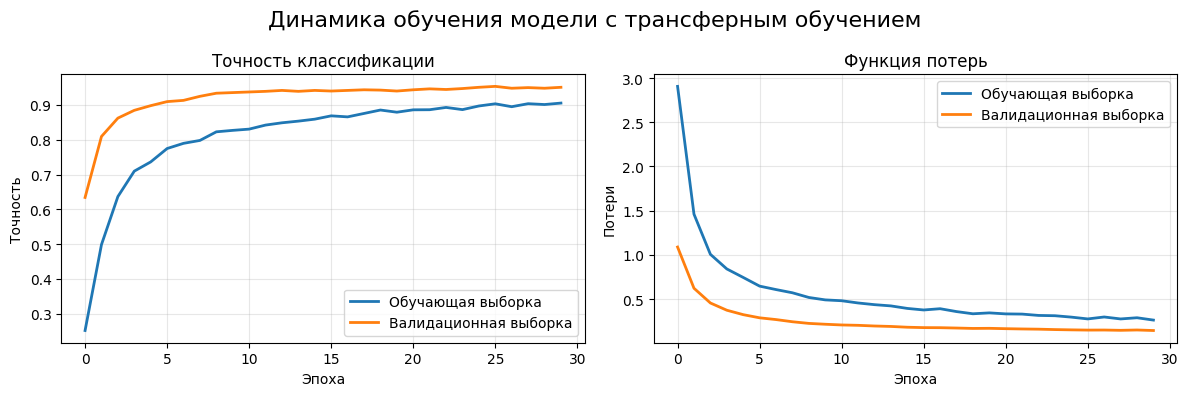

In [ ]:
# 6.8. Визуализация изменения точности и функции потерь в процессе обучения
def plot_transfer_training_results(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Точность классификации
    axes[0].plot(history.history["accuracy"], label="Обучающая выборка", linewidth=2)
    axes[0].plot(history.history["val_accuracy"], label="Валидационная выборка", linewidth=2)
    axes[0].set_title("Точность классификации")
    axes[0].set_xlabel("Эпоха")
    axes[0].set_ylabel("Точность")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Функция потерь
    axes[1].plot(history.history["loss"], label="Обучающая выборка", linewidth=2)
    axes[1].plot(history.history["val_loss"], label="Валидационная выборка", linewidth=2)
    axes[1].set_title("Функция потерь")
    axes[1].set_xlabel("Эпоха")
    axes[1].set_ylabel("Потери")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle("Динамика обучения модели с трансферным обучением", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_transfer_training_results(history_tl)

По представленным графикам видно, что процесс обучения модели с трансферным обучением протекает стабильно. Точность на обучающей и валидационной выборках монотонно возрастает в течение первых эпох и далее выходит на плато, что указывает на корректную настройку архитектуры модели и параметров обучения. Значения валидационной точности остаются высокими и близкими к обучающим, что свидетельствует об отсутствии выраженного переобучения.

График функции потерь демонстрирует уверенное снижение как на обучающей, так и на валидационной выборках. При этом валидационные потери не начинают расти на поздних этапах обучения, что подтверждает устойчивость модели и эффективность использования механизма ранней остановки. Отсутствие резких колебаний на графиках также говорит о корректной предобработке данных и согласованной работе слоя аугментации и предобученной сверточной базы.

In [ ]:
# 6.9. Анализ полученных результатов
print("\n" + "=" * 60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ МОДЕЛИ С ТРАНСФЕРНЫМ ОБУЧЕНИЕМ")
print("=" * 60)

best_val_acc_tl = max(history_tl.history["val_accuracy"])
best_val_loss_tl = min(history_tl.history["val_loss"])
final_train_acc_tl = history_tl.history["accuracy"][-1]
final_val_acc_tl = history_tl.history["val_accuracy"][-1]

print("Основные показатели качества модели:")
print(f"  Лучшая валидационная точность: {best_val_acc_tl:.4f} ({best_val_acc_tl*100:.1f}%)")
print(f"  Минимальные валидационные потери: {best_val_loss_tl:.4f}")
print(f"  Финальная обучающая точность: {final_train_acc_tl:.4f} ({final_train_acc_tl*100:.1f}%)")
print(f"  Финальная валидационная точность: {final_val_acc_tl:.4f} ({final_val_acc_tl*100:.1f}%)")
print(f"  Точность на тестовой выборке: {test_results_tl[1]:.4f} ({test_results_tl[1]*100:.1f}%)")

overfitting_gap_tl = final_train_acc_tl - final_val_acc_tl
print("\nАнализ переобучения:")
print(f"  Разница между обучающей и валидационной точностью: {overfitting_gap_tl:.4f}")


АНАЛИЗ РЕЗУЛЬТАТОВ МОДЕЛИ С ТРАНСФЕРНЫМ ОБУЧЕНИЕМ
Основные показатели качества модели:
  Лучшая валидационная точность: 0.9535 (95.3%)
  Минимальные валидационные потери: 0.1449
  Финальная обучающая точность: 0.9055 (90.5%)
  Финальная валидационная точность: 0.9508 (95.1%)
  Точность на тестовой выборке: 0.9588 (95.9%)

Анализ переобучения:
  Разница между обучающей и валидационной точностью: -0.0453


Полученные значения метрик свидетельствуют о высокой эффективности модели с трансферным обучением. Максимальная валидационная точность достигает 95.35 %, при этом минимальное значение валидационных потерь составляет 0.1449, что указывает на хорошее качество аппроксимации и корректную настройку архитектуры классификатора. Финальные значения обучающей и валидационной точности близки друг к другу и превышают 90 %, что говорит о стабильности процесса обучения.

Точность модели на тестовой выборке составляет 95.88 %, что подтверждает способность модели корректно обобщать информацию на ранее не встречавшихся данных. Отрицательное значение разницы между обучающей и валидационной точностью указывает на отсутствие переобучения и свидетельствует о том, что модель не адаптируется избыточно к обучающей выборке.

Таким образом, использование предобученной сверточной базы в сочетании с дообучаемым полносвязным классификатором и механизмами регуляризации позволяет получить устойчивую и высокоточную модель для задачи многоклассовой классификации изображений транспортных средств.

### 7. Сравнительный анализ моделей

Поскольку исходный набор данных является практически сбалансированным — количество изображений в каждом классе отличается незначительно — в качестве основной метрики качества была использована точность классификации (accuracy). В условиях отсутствия выраженного дисбаланса классов данная метрика адекватно отражает обобщающую способность моделей на тестовой выборке. Дополнительно анализировались значения функции потерь, характеризующие степень уверенности модели в принимаемых решениях.

In [ ]:
# Формирование данных для таблицы
comparison_data = {
    "Модель": [
        "Сверточная нейронная сеть «с нуля»",
        "Сверточная нейронная сеть с трансферным обучением"
    ],
    "Accuracy (test)": [
        test_results[1],
        test_results_tl[1]
    ],
    "Loss (test)": [
        test_results[0],
        test_results_tl[0]
    ]
}
comparison_table = pd.DataFrame(comparison_data)

# Округление значений для наглядности
comparison_table["Accuracy (test)"] = comparison_table["Accuracy (test)"].round(4)
comparison_table["Loss (test)"] = comparison_table["Loss (test)"].round(4)

# Вывод таблицы
print("\n" + "=" * 60)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ МОДЕЛЕЙ (ТЕСТОВАЯ ВЫБОРКА)")
print("=" * 60)
display(comparison_table)


СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ МОДЕЛЕЙ (ТЕСТОВАЯ ВЫБОРКА)


,Модель,Accuracy (test),Loss (test)
0,Сверточная нейронная сеть «с нуля»,0.8405,0.5318
1,Сверточная нейронная сеть с трансферным обучением,0.9588,0.1516


По результатам сравнительного анализа на тестовой выборке установлено, что обе модели корректно решают задачу многоклассовой классификации изображений при использовании метрики accuracy, адекватной для сбалансированного набора данных. Модель, построенная «с нуля», демонстрирует точность 0.8405 при значении функции потерь 0.5318, что соответствует удовлетворительному качеству классификации без использования предобученных весов.

Модель с трансферным обучением показывает более высокие значения точности (0.9588) и существенно меньшие потери (0.1516), что указывает на более уверенные и устойчивые предсказания на тестовых данных. Низкое значение функции потерь свидетельствует о высокой согласованности выходных вероятностей с истинными метками классов. В целом, анализ тестовых метрик подтверждает эффективность применения трансферного обучения для повышения качества классификации при работе с изображениями.

### 8. Выводы

В ходе выполнения лабораторной работы была решена задача многоклассовой классификации изображений транспортных средств на основе сверточных нейронных сетей. Исходный датасет, состоящий из 5590 изображений и включающий 7 классов, был проанализирован, признан практически сбалансированным и корректно разделён на обучающую, валидационную и тестовую выборки в соотношении 60 / 20 / 20. Для повышения устойчивости обучения применялась нормализация данных и аугментация изображений на уровне слоёв нейронной сети.

В рамках работы были реализованы и обучены две модели: сверточная нейронная сеть, построенная «с нуля», и модель с трансферным обучением на основе предобученной архитектуры ResNet50V2. Для обеих моделей использовались методы регуляризации и ранней остановки, что обеспечило стабильную сходимость и предотвратило переобучение. Анализ динамики точности и функции потерь показал корректное поведение процесса обучения и согласованность результатов на обучающей и валидационной выборках.

По результатам тестирования модель, построенная «с нуля», достигла точности классификации 84.1% при значении функции потерь 0.5318, что является удовлетворительным результатом для архитектуры без использования предобученных весов. Модель с трансферным обучением продемонстрировала более высокое качество — точность 95.88% и значение функции потерь 0.1516, что свидетельствует о высокой эффективности использования предобученной сверточной базы для извлечения информативных признаков.

Таким образом, в работе на практике показано, что трансферное обучение является более эффективным подходом для решения задачи классификации изображений при ограниченном объёме данных. Полученные результаты подтверждают целесообразность применения предобученных моделей глубокого обучения и демонстрируют влияние архитектурных решений и методов регуляризации на качество и обобщающую способность нейронных сетей.
